In [1]:
import os
import json
import hoomd
import codecs
import pyximport

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)

from polykit.generators.initial_conformations import grow_cubic
from LEF_dynamics.lattice_translocators import LEFTranslocatorDirectional

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home1/tortora/software/polychrom-hoomd/examples/LEF_dynamics/lattice_translocators.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:0,
                 from /home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home1/tortora/.pyxbld/temp.linux-x86_64-cpython-310/pyrex/LEF_dynamics/lattice_translocators.c:746:
/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/numpy/core/include/nump

In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100 80GB PCIe 108 SM_8.0 @ 1.41 GHz, 81069 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 53113


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Parse force parameters
with open("force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes,
                 bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                 angle_type_list=list(angle_types))

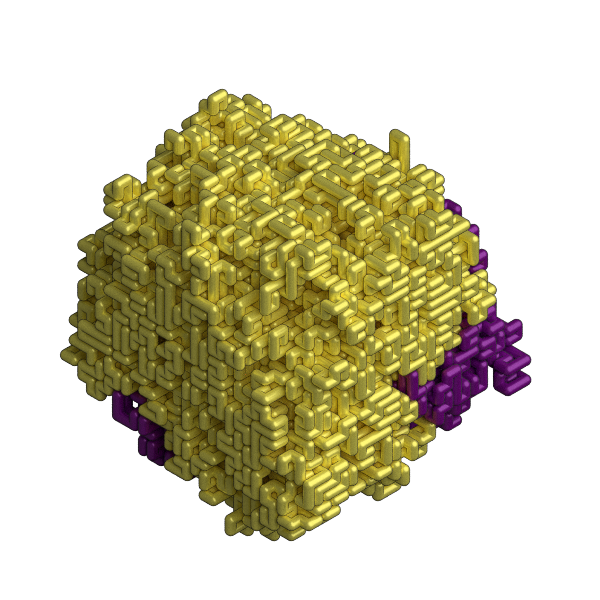

In [12]:
# Render individual chromosomes using the Fresnel backend
render.fresnel(snapshot, show_chromosomes=True).static(pathtrace=True)

In [13]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

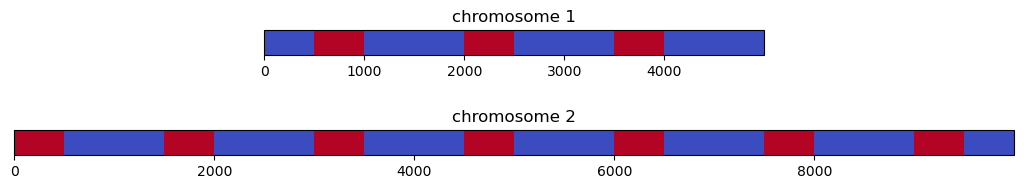

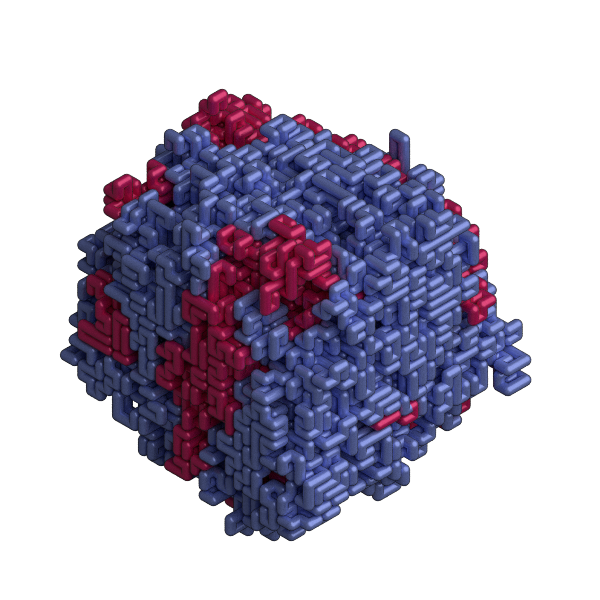

In [14]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [15]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [17]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [19]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [20]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

Setting up DPD with the conservative force contribution disabled


In [21]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces \
            + dpd_forces + attraction_forces

In [22]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/polychrom-hoomd/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [23]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [24]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           5221.34721     0:00:17.236931           0.90866          
       20000           6265.22918     0:00:12.768886           0.98069          
       30000           6645.04445     0:00:10.534166           1.01083          
       40000           6903.92840     0:00:08.690704           1.02336          
       50000           7066.95451     0:00:07.075184           1.03312          
       60000           7181.40397     0:00:05.569941           1.02787          
       70000           7263.43862     0:00:04.130275           1.04341          
       80000           7327.20875     0:00:02.729552           1.03753          
       90000           7378.77743     0:00:01.355238           1.02978          
      100000           7416.14261        0:00:00               1.00690          


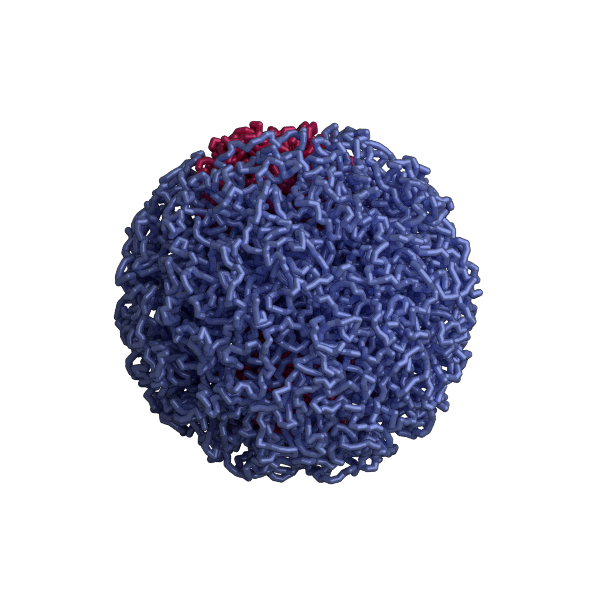

In [25]:
# Visualize equilibrated domains in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated, show_compartments=True, cmap="coolwarm").static()

In [26]:
# Parse extrusion parameters
with open("extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)
    
extrusion_dict['LEF_lifetime'] *= extrusion_dict['LEF_velocity']
extrusion_dict['LEF_stall'] = 1 - (1-extrusion_dict['LEF_stall'])**(1/extrusion_dict['LEF_velocity'])

In [27]:
# Add loop extruders
LEF_pos = extrude.compute_LEF_pos(LEFTranslocatorDirectional, number_of_monomers, **extrusion_dict)

extrude.update_topology(system, LEF_pos[0])

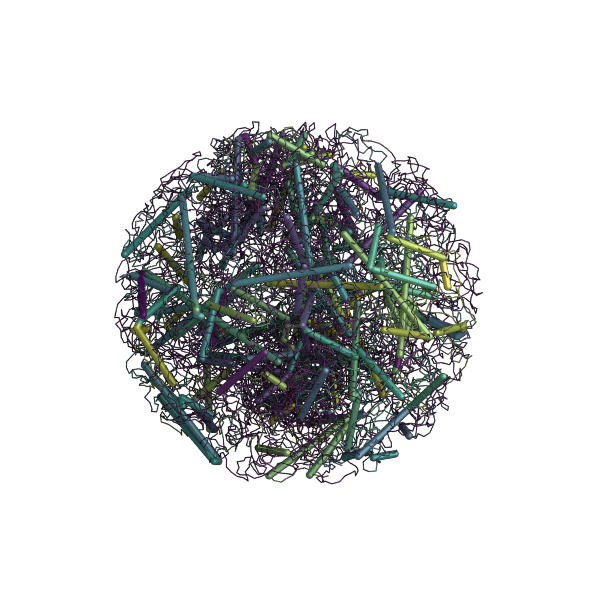

In [28]:
# Visualize new CTCF bonds 
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show_loops=True, rescale_backbone_bonds=0.15).static()

In [29]:
# Define relaxation force field
relax_field = repulsion_forces + bonded_forces + confinement_forces

In [30]:
# Relax CTCF bonds via the fast inertial relaxation engine
system.operations.remove(dpd_integrator)
system.operations.remove(system.operations.writers[0])

fire = hoomd.md.minimize.FIRE(dt=1e-2, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

In [31]:
# Update simulation engine
system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger, period=500))

In [32]:
# Run
system.run(5e3)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      100500           1704.30482     0:00:02.640373           0.00010          
      101000           3311.49975     0:00:01.207912           0.00004          
      101500           4947.34167     0:00:00.707451           0.00004          
      102000           6578.57930     0:00:00.456026           0.00004          
      102500           8193.46949     0:00:00.305121           0.00004          
      103000           9805.71668     0:00:00.203963           0.00004          
      103500          11401.10785     0:00:00.131566           0.00004          
      104000          12994.94695     0:00:00.076953           0.00004          
      104500          14569.34770     0:00:00.034319           0.00004          
      105000          16144.71139        0:00:00               0.00004          


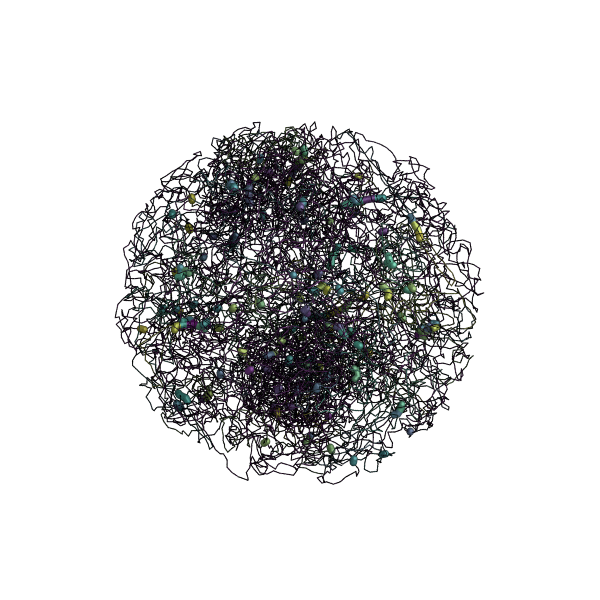

In [33]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_loops=True, rescale_backbone_bonds=0.15).static()

In [34]:
# Update simulation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [35]:
# Run
steps_per_loop = extrusion_dict['3D_to_1D_steps']/extrusion_dict['LEF_velocity']

for LEF_bonds in LEF_pos:
    extrude.update_topology(system, LEF_bonds, thermalize=False)    
    system.run(steps_per_loop)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      110000           6080.97785        0:00:00               1.37339          
      120000           5913.64298        0:00:00               2.15645          
      130000           4679.49019        0:00:00               2.19782          
      140000           4724.93292        0:00:00               2.10271          
      150000           4783.53886        0:00:00               2.15642          
      160000           5937.10842        0:00:00               2.19628          
      170000           4720.00190        0:00:00               2.20566          
      180000           5914.34600        0:00:00               2.16263          
      190000           4765.89630        0:00:00               2.23710          
      200000           5818.20308        0:00:00               2.21054          
      210000           5934.45263        0:00:00               2.14141          
      220000           5923.

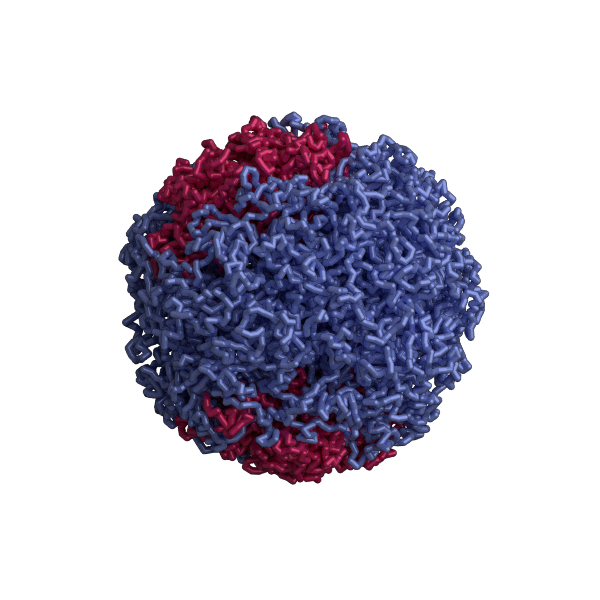

In [36]:
# Visualize new conformation
final_snapshot = system.state.get_snapshot()
render.fresnel(final_snapshot, show_compartments=True, cmap="coolwarm").static()

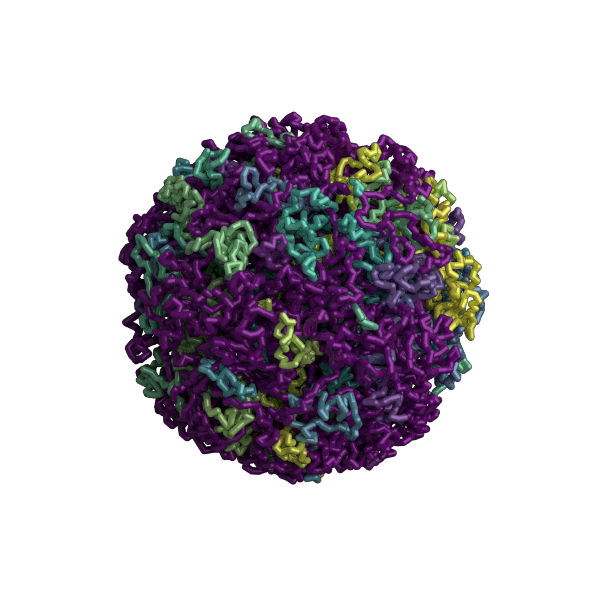

In [37]:
# Visualize individual loops
render.fresnel(final_snapshot, show_loops=True).static()